In [7]:
import spacy
spacy_nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
import utility_functions as utils
import importlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import librosa
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from fuzzywuzzy import process
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

importlib.reload(utils)

<module 'utility_functions' from '/Users/abelboros/Documents/Personal/Thesis/PopMusicInformationRetrieval/Emotion Analysis/utility_functions.py'>

In [9]:
data = '../Data/pkl_data/df_preprocessed_with_features.pkl'
df = pd.read_pickle(data)

In [10]:
df

,Artist,Album,Song,Coast,Release Year,Tempo1,Tempo2,Duration (s),Sample Rate (Hz),Path,Lyrics,Tokens,Processed_Lyrics,Valence,Arousal,Tempo,Mode,Loudness,Danceability,Energy
0,Big L,Lifestylez Ov Da Poor and Dangerous,8 Iz Enuff.mp3,east_coast,1995,96.774194,48.000000,298.840000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"\n\nYo\nMy crew is in the house\nTerra, Herb M...","[crew, house, bless, big, mike, imma, set, fol...",crew house terra herb mcgruff buddah bless big...,0.552087,0.492146,95.338983,Major,0.238469,1.715371,21.964646
1,Big L,Lifestylez Ov Da Poor and Dangerous,Da Graveyard.mp3,east_coast,1995,93.750000,46.511628,323.760000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\n[Intro:]\nIt's the number one crew in the ...,"[number, one, crew, big, nigga, men, win, kill...",number one crew area big lightin nigga incense...,0.453056,0.554372,93.750000,Major,0.210434,1.699776,20.848735
2,Big L,Lifestylez Ov Da Poor and Dangerous,I Don't Understand It.mp3,east_coast,1995,93.750000,47.244094,260.226667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\n[Verse 1]\nThere are too many MC's who are...,"[many, mcs, ask, even, supposed, make, rap, kn...",many mcs overrated ask even supposed make rap ...,0.587465,0.482054,93.750000,Minor,0.195434,1.555876,20.992520
3,Big L,Lifestylez Ov Da Poor and Dangerous,"No Endz, No Skinz.mp3",east_coast,1995,100.000000,50.420168,208.733333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\n[Verse 1:]\nLet me get to the point real q...,"[let, point, real, quick, pocket, thick, mad, ...",let get point real quick pocket thick mad chic...,0.602089,0.470871,100.446429,Minor,0.159886,1.788838,20.780705
4,Big L,Lifestylez Ov Da Poor and Dangerous,MVP.mp3,east_coast,1995,86.956522,43.478261,218.866667,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\n[Big L]\n A yo spark up the phillies and p...,"[pass, make, quick, money, grip, ass, street, ...",spark phillies pass stout make quick money gri...,0.565139,0.503215,86.538462,Major,0.157873,1.474109,21.115999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1363,Dr.Dre,The Chronic,Dr. Dre - The Day the Niggaz Took Over (feat. ...,west_coast,1992,93.750000,46.875000,273.206000,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\nI'ma say this and I'ma end mine\nIf you ai...,"[say, end, mine, point, one, south, shit, need...",say end mine africans united states period poi...,0.544091,0.489983,93.750000,Minor,0.151968,1.410891,21.314680
1364,Dr.Dre,The Chronic,"Dr. Dre - Bitches Ain't Shit (feat. Jewell, Sn...",west_coast,1992,92.307692,46.153846,287.207625,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,\n\nBitches ain't shit but hoes and tricks\n\n...,"[bitch, shit, hoe, trick, bitch, shit, hoe, tr...",bitch shit hoe trick bitch shit hoe trick lick...,0.441069,0.539923,92.213115,Minor,0.157478,1.474181,22.362968
1365,Dr.Dre,The Chronic,Dr. Dre - Stranded On Death Row (feat. Bushwic...,west_coast,1992,90.909091,45.801527,287.335333,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"\n\n""Yes, it is I,"" says me\nAnd all who agree...","[yes, say, three, yes, house, sure, want, talk...",yes say agree three yes house sure want talk h...,0.494128,0.492990,181.451613,Minor,0.134036,1.185605,20.261206
1366,Dr.Dre,The Chronic,Dr. Dre - Nuthin' but a ＂G＂ Thang (feat. Snoop...,west_coast,1992,95.238095,47.244094,238.677917,48000,/Users/borosabel/Documents/Uni/Thesis/PopMIR/D...,"\n\nOne, two, three and to the four\nSnoop Dog...","[one, two, three, four, dog, dr, dre, door, re...",one two three four snoop doggy dog dr dre door...,0.541468,0.477184,93.750000,Minor,0.171882,1.338071,22.064955


In [11]:
def load_vad_lexicon(filepath):
    vad_df = pd.read_csv(filepath, sep='\t', header=None, names=['Word', 'Valence', 'Arousal', 'Dominance'])
    vad_lexicon = vad_df.set_index('Word')[['Valence', 'Arousal']].to_dict(orient='index')
    return vad_lexicon

def process_context(tokens):
    processed_tokens = []
    negate_next = False

    for i, token in enumerate(tokens):
        if token in ["not", "never", "don't", "can't"]:
            negate_next = True
        elif negate_next:
            processed_tokens.append(f"not_{token}")  # Append with "not_" prefix to indicate negation
            negate_next = False
        else:
            processed_tokens.append(token)
    return processed_tokens

# Calculate valence and arousal based on processed tokens
def calculate_valence_arousal(tokens, vad_lexicon):
    total_valence = 0.0
    total_arousal = 0.0
    word_count = 0

    for token in tokens:
        if token.startswith("not_"):
            actual_token = token[4:]
            if actual_token in vad_lexicon:
                valence = 1.0 - vad_lexicon[actual_token]['Valence']
                arousal = vad_lexicon[actual_token]['Arousal']
                total_valence += valence
                total_arousal += arousal
                word_count += 1
        elif token in vad_lexicon:
            valence = vad_lexicon[token]['Valence']
            arousal = vad_lexicon[token]['Arousal']
            total_valence += valence
            total_arousal += arousal
            word_count += 1

    if word_count == 0:
        return 0.5, 0.5

    average_valence = total_valence / word_count
    average_arousal = total_arousal / word_count

    return average_valence, average_arousal

def calculate_row_valence_arousal(row, vad_lexicon):
    processed_tokens = process_context(row['Tokens'])
    average_valence, average_arousal = calculate_valence_arousal(processed_tokens, vad_lexicon)
    return pd.Series([average_valence, average_arousal], index=['Valence', 'Arousal'])

def extract_audio_features(audio_path):
    try:
        y, sr = librosa.load(audio_path, sr=None)
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        chroma = librosa.feature.chroma_cqt(y=y, sr=sr)
        mode = 'Major' if np.mean(chroma[0]) > np.mean(chroma[7]) else 'Minor'
        rms = librosa.feature.rms(y=y)
        loudness = np.mean(rms)
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        danceability = np.std(onset_env)
        energy = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))

        return pd.Series([tempo, mode, loudness, danceability, energy])

    except Exception as e:
        print(f"Error processing file {audio_path}: {e}")
        return pd.Series([None, None, None, None, None])

nrc_vad_lexicon_path = '../NRC-VAD-Lexicon/NRC-VAD-Lexicon.txt'
vad_dict = load_vad_lexicon(nrc_vad_lexicon_path)

In [12]:
df[['Valence', 'Arousal']] = df.apply(lambda row: calculate_row_valence_arousal(row, vad_dict), axis=1)

In [13]:
df['Valence']

0       0.553352
1       0.453126
2       0.585853
3       0.605056
4       0.567975
          ...   
1363    0.544091
1364    0.441069
1365    0.494128
1366    0.535165
1367    0.460066
Name: Valence, Length: 1368, dtype: float64

In [14]:
# Calculating audio features
# tqdm.pandas()
# df[['Tempo', 'Mode', 'Loudness', 'Danceability', 'Energy']] = df['Path'].progress_apply(lambda path: extract_audio_features(path))

In [15]:
# Feature scaling and encoding

scaler = MinMaxScaler()
le = LabelEncoder()

df['Mode'] = le.fit_transform(df['Mode'])
features_to_scale = ['Valence', 'Arousal', 'Tempo', 'Loudness', 'Danceability', 'Energy']

df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [27]:
# Your defined feature weights
weights = np.array([1.0, 0.7, 1.0, 0.8, 1.0, 0.5, 0.9])

# Your features
features = ['Valence', 'Arousal', 'Tempo', 'Loudness', 'Mode', 'Danceability', 'Energy']

# Standardize features first
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Multiply features by weights
X_weighted = X_scaled * weights

cluster_range = range(2, 11)
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['pseudo_label'] = kmeans.fit_predict(X_weighted)
    labels = kmeans.fit_predict(X_weighted)
    silhouette_avg = silhouette_score(X_weighted, labels)
    silhouette_scores.append(silhouette_avg)

# Check scores
best_k = cluster_range[np.argmax(silhouette_scores)]
print(f'Best number of clusters: {best_k}')

Best number of clusters: 3


<b>Results</b>

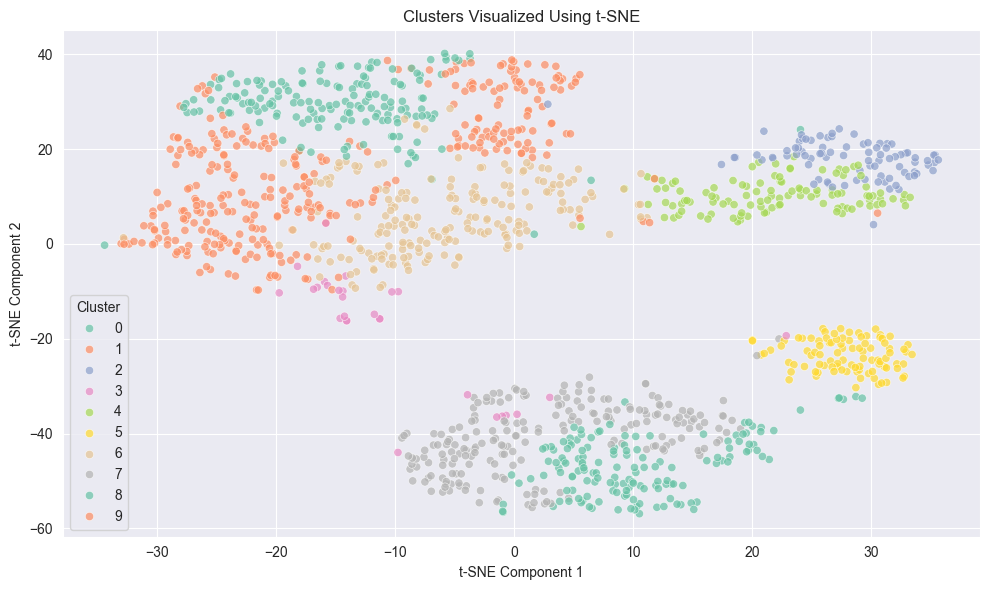

In [28]:
# Reduce features to 2 dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(X_weighted)

# Add t-SNE components to the DataFrame
df['tSNE1'] = tsne_features[:, 0]
df['tSNE2'] = tsne_features[:, 1]

# Plotting the clusters using t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='tSNE1', y='tSNE2', hue='pseudo_label', palette='Set2', alpha=0.7)
plt.title('Clusters Visualized Using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

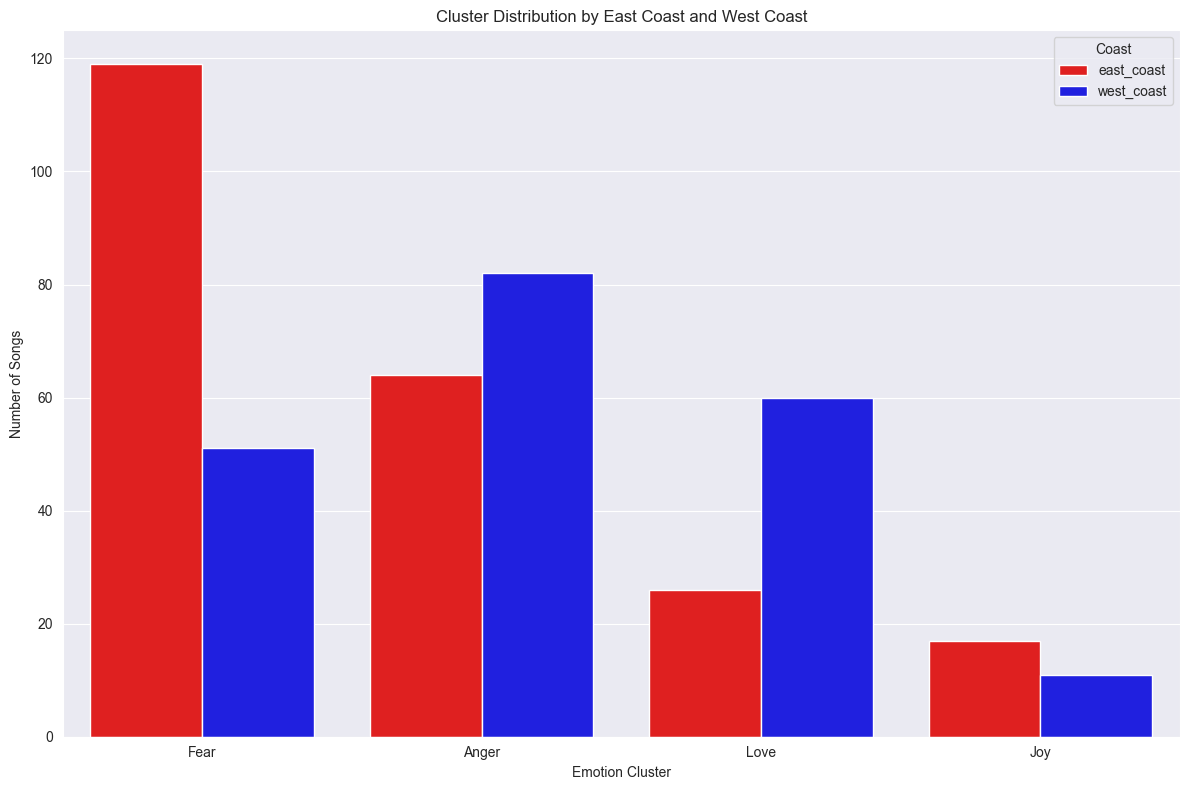

In [29]:
emotion_labels = {0: 'Anger', 1: 'Fear', 2: 'Love', 3: 'Joy'}


df['pseudo_label'] = df['pseudo_label'].map(emotion_labels)
cluster_counts = df.groupby(['pseudo_label', 'Coast']).size().reset_index(name='Count')
cluster_counts = cluster_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=cluster_counts, x='pseudo_label', y='Count', hue='Coast', palette={'east_coast': 'red', 'west_coast': 'blue'})
plt.title('Cluster Distribution by East Coast and West Coast')
plt.xlabel('Emotion Cluster')
plt.ylabel('Number of Songs')
plt.legend(title='Coast')
plt.tight_layout()

plt.show()

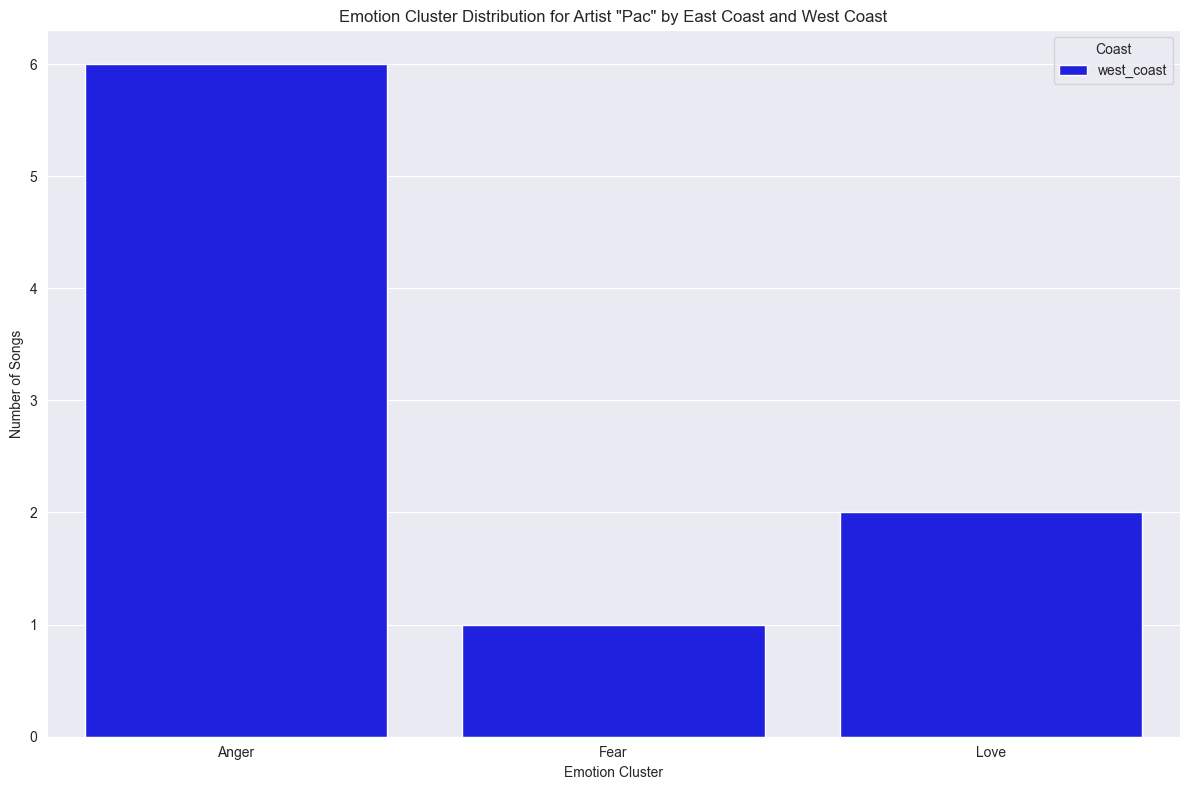

In [30]:
pac_songs_df = df[(df['Artist'] == 'Pac')].copy()
pac_songs_df = pac_songs_df[pac_songs_df['Release Year'] == 1996]

pac_cluster_counts = pac_songs_df.groupby(['pseudo_label', 'Coast']).size().reset_index(name='Count')

plt.figure(figsize=(12, 8))
sns.barplot(data=pac_cluster_counts, x='pseudo_label', y='Count', hue='Coast', palette={'east_coast': 'red', 'west_coast': 'blue'})
plt.title('Emotion Cluster Distribution for Artist "Pac" by East Coast and West Coast')
plt.xlabel('Emotion Cluster')
plt.ylabel('Number of Songs')
plt.legend(title='Coast')
plt.tight_layout()

plt.show()

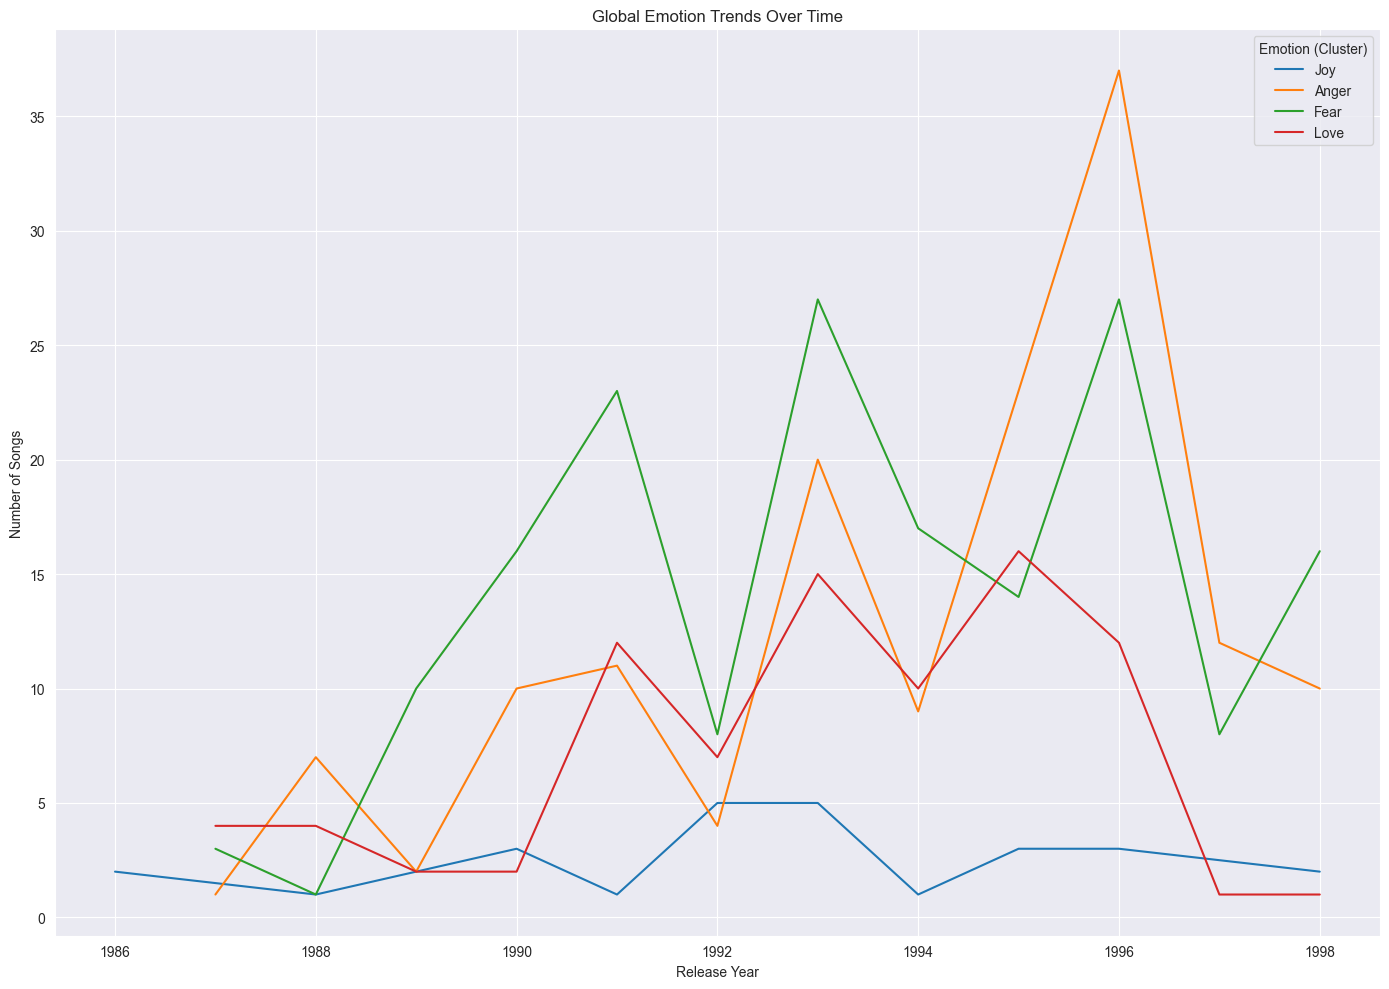

In [31]:
emotion_over_time = df.groupby(['Release Year', 'pseudo_label']).size().reset_index(name='Count')

plt.figure(figsize=(14, 10))

sns.lineplot(data=emotion_over_time, x='Release Year', y='Count', hue='pseudo_label', markers=True)

plt.title('Global Emotion Trends Over Time')
plt.xlabel('Release Year')
plt.ylabel('Number of Songs')
plt.legend(title='Emotion (Cluster)')
plt.tight_layout()
plt.savefig('./Global Emotions Over Time.png')

# Show the plot
plt.show()

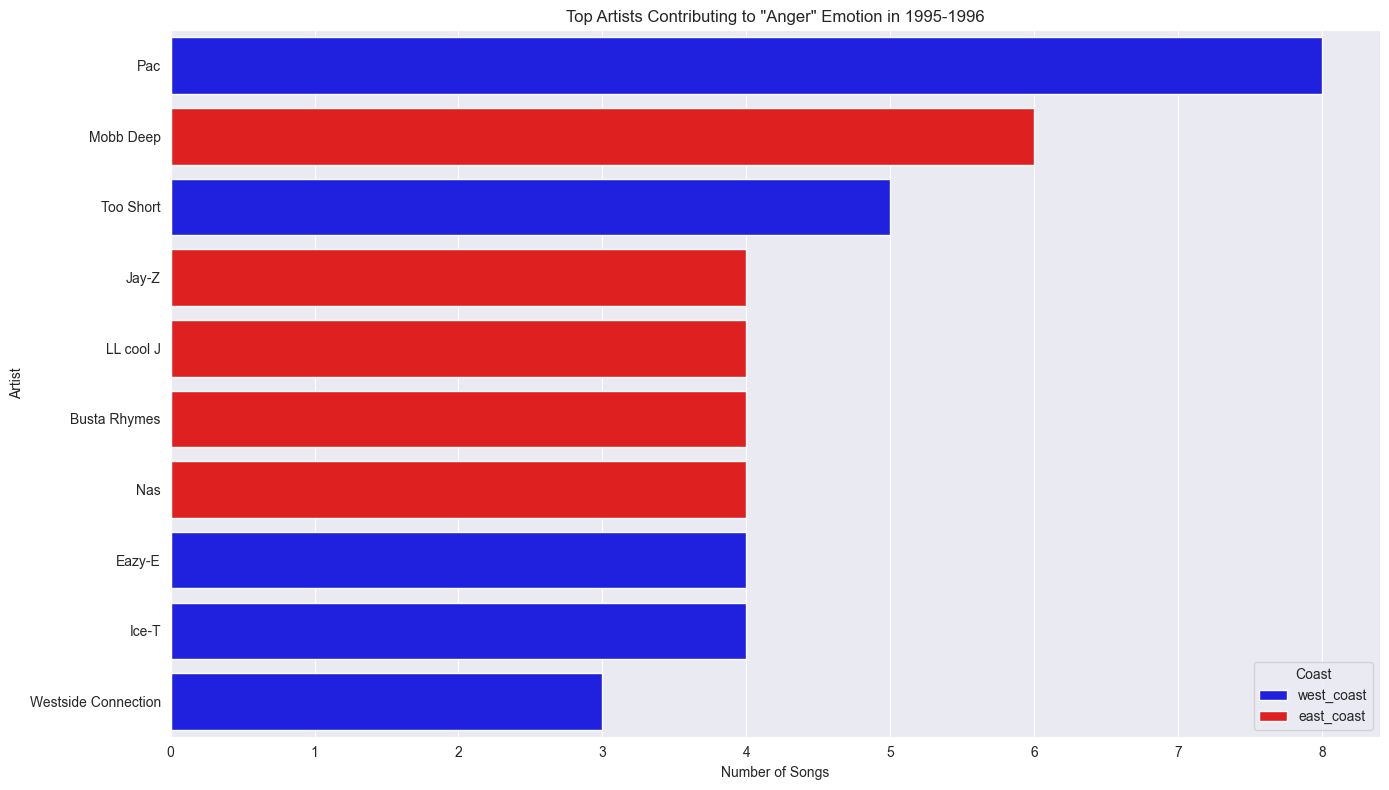

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

anger_data = df[(df['pseudo_label'] == 'Anger') & (df['Release Year'].isin([1995, 1996]))]
top_artists_counts = anger_data.groupby(['Artist', 'Coast']).size().reset_index(name='Count')
top_artists_counts = top_artists_counts.sort_values(by='Count', ascending=False).head(10)
plt.figure(figsize=(14, 8))

sns.barplot(data=top_artists_counts, x='Count', y='Artist', hue='Coast', palette={'east_coast': 'red', 'west_coast': 'blue'})
plt.title('Top Artists Contributing to "Anger" Emotion in 1995-1996')
plt.xlabel('Number of Songs')
plt.ylabel('Artist')
plt.legend(title='Coast')
plt.tight_layout()
plt.savefig('Top_contributors_to_anger_emotion_95_96.png')

plt.show()

In [34]:
# Sort the dataframe by 'Valence' in ascending order (assuming lower valence means more anger)
sorted_df = df.sort_values(by='Valence', ascending=True)

# Select the top two songs
top_angry_songs = sorted_df.head(30)

# Display the artist, title, release year, valence, and arousal
print(top_angry_songs[['Artist', 'Song', 'Release Year', 'Valence', 'Arousal']])


                   Artist  \
1295                Ice-T   
1223                Ice-T   
761                 N.W.A   
987                   Pac   
1065                  Pac   
1091         Cypress Hill   
1331         The Pharcyde   
21           Beastie Boys   
1121               Eazy-E   
1017                  Pac   
1281                Ice-T   
1139               Eazy-E   
978                 Luniz   
1085         Cypress Hill   
1125               Eazy-E   
734                 N.W.A   
756                 N.W.A   
1062                  Pac   
880             Too Short   
1364               Dr.Dre   
1186  Digital Underground   
1061                  Pac   
50           Beastie Boys   
1245                Ice-T   
942            Snoop Dogg   
913             Too Short   
1289                Ice-T   
520          Busta Rhymes   
824              Ice Cube   
661            Gang Starr   

                                                                              Song  \
1295          

<b>Billboard analysis</b>

In [36]:
billboard_100_df = pd.read_csv('../Data/billboard/hot-100-current.csv')
billboard_200_df = pd.read_csv('../Data/billboard/billboard-200-current.csv')

In [37]:
# Define artist name or use the mapped version if needed
artist_name = 'n.w.a'

# Filter the DataFrame for 2Pac's songs
tupac_songs = billboard_100_df[billboard_100_df['performer'].str.contains(artist_name, case=False, na=False)]

# Display the results
print(tupac_songs['performer'].value_counts())

performer
Randy Newman                           32
Calvin Harris Featuring John Newman    20
John Newman                            18
Thunderclap Newman                     10
Randy Newman & Paul Simon               8
Troy Newman                             4
N.W.A                                   2
Name: count, dtype: int64


In [38]:
hip_hop_artists = list(set(df['Artist']))
billboard_artists = list(set(billboard_100_df['performer']))

artist_mapping = {}

# Perform fuzzy matching
for artist in hip_hop_artists:
    matches = process.extract(artist, billboard_artists, limit=5)  # Get top 5 matches
    filtered_matches = [match[0] for match in matches if match[1] > 80]
    artist_mapping[artist] = filtered_matches

artist_mapping['Eazy-E'] = ['Eazy-E']
artist_mapping['Dr.Dre'] = ['Dr. Dre']
artist_mapping['De La Soul'] = ['De La Soul', 'De La Soul Featuring Chaka Khan']
artist_mapping['The Notorious B.I.G'] = ['The Notorious B.I.G.']
artist_mapping['Jay-Z'] = ['Jay-Z']
artist_mapping['LL cool J'] = ['LL Cool J']
artist_mapping['Busta Rhymes'] = ['Busta Rhymes']
artist_mapping['Pac'] = ['2Pac + Outlawz', '2Pac']
artist_mapping['Run-DMC'] = ['Run-D.M-C.']
artist_mapping['Gang Starr'] = ['Gang Starr']
artist_mapping['Ice-T'] = ['Ice-T']
artist_mapping['N.W.A'] = ['N.W.A']
artist_mapping['Wu Tang Clan'] = ['Wu-Tang Clan']
artist_mapping['Erik B and Rakim'] = []
artist_mapping['Westside Connection'] = ['Westside Connection', 'Westside Connection Featuring Nate Dogg']
artist_mapping['A Tribe Called Quest'] = ['A Tribe Called Quest']
artist_mapping['Ice Cube'] = ['Ice Cube']
artist_mapping['Too Short'] = ['Too $hort']
artist_mapping['Nas'] = ['Nas']
artist_mapping['Public Enemy'] = ['Public Enemy']
artist_mapping['Big L'] = []
artist_mapping['Cypress Hill'] = ['Cypress Hill']
artist_mapping['Digital Underground'] = ['Digital Underground']
artist_mapping['Beastie Boys'] = ['Beastie Boys']
artist_mapping['Souls Of Mischief'] = ['Souls Of Mischief']
artist_mapping['The Pharcyde'] = ['The Pharcyde']
artist_mapping['Coolio'] = ['Coolio', 'Coolio Featuring L.V.']
artist_mapping['Snoop Dogg'] = ['Snoop Dogg']
artist_mapping['Mobb Deep'] = ['Mobb Deep']
artist_mapping['Warren G'] = ['Warren G']

In [39]:
artist_mapping

{'The Pharcyde': ['The Pharcyde'],
 'Dr.Dre': ['Dr. Dre'],
 'Big L': [],
 'Jay-Z': ['Jay-Z'],
 'Snoop Dogg': ['Snoop Dogg'],
 'Public Enemy': ['Public Enemy'],
 'Run-DMC': ['Run-D.M-C.'],
 'Digital Underground': ['Digital Underground'],
 'Too Short': ['Too $hort'],
 'Cypress Hill': ['Cypress Hill'],
 'Ice Cube': ['Ice Cube'],
 'Westside Connection': ['Westside Connection',
  'Westside Connection Featuring Nate Dogg'],
 'Luniz': ['Luniz'],
 'N.W.A': ['N.W.A'],
 'Nas': ['Nas'],
 'De La Soul': ['De La Soul', 'De La Soul Featuring Chaka Khan'],
 'The Notorious B.I.G': ['The Notorious B.I.G.'],
 'Beastie Boys': ['Beastie Boys'],
 'Mobb Deep': ['Mobb Deep'],
 'Coolio': ['Coolio', 'Coolio Featuring L.V.'],
 'Puff Daddy': ['Puff Daddy Featuring R. Kelly',
  'SWV (Featuring Puff Daddy)',
  "The Notorious B.I.G. Featuring Puff Daddy & Lil' Kim",
  'Mase Featuring Puff Daddy',
  'Puff Daddy & The Family Featuring The Notorious B.I.G. & Busta Rh'],
 'Gang Starr': ['Gang Starr'],
 'Wu Tang Clan': [

In [40]:
# There are some mappings that I don't like so needs some more manual filtering

In [41]:
billboard_100_df['chart_week'] = pd.to_datetime(billboard_100_df['chart_week'])

# Filter rows where the year is between 1986 and 1998 (inclusive)
billboard_100_df_86_98 = billboard_100_df[(billboard_100_df['chart_week'].dt.year >= 1986) &
                               (billboard_100_df['chart_week'].dt.year <= 1998)]

In [42]:
mapped_artists = []
for artists in artist_mapping.values():
    mapped_artists.extend(artists)
mapped_artists = list(set(mapped_artists))
filtered_billboard_df = billboard_100_df_86_98[billboard_100_df_86_98['performer'].isin(mapped_artists)]

In [43]:
filtered_billboard_df

,chart_week,current_week,title,performer,last_week,peak_pos,wks_on_chart
161585,1986-12-20,86,(You Gotta) Fight For Your Right (To Party!),Beastie Boys,NaN,86,1
161667,1986-12-27,68,(You Gotta) Fight For Your Right (To Party!),Beastie Boys,86.0,68,2
161767,1987-01-03,68,(You Gotta) Fight For Your Right (To Party!),Beastie Boys,68.0,68,3
161862,1987-01-10,63,(You Gotta) Fight For Your Right (To Party!),Beastie Boys,68.0,63,4
161951,1987-01-17,52,(You Gotta) Fight For Your Right (To Party!),Beastie Boys,63.0,52,5
...,...,...,...,...,...,...,...
223876,1998-11-28,77,Dr. Greenthumb,Cypress Hill,79.0,70,11
223967,1998-12-05,68,Changes,2Pac,NaN,68,1
224054,1998-12-12,55,Changes,2Pac,68.0,55,2
224142,1998-12-19,43,Changes,2Pac,55.0,43,3


In [44]:
east_coast_artists = list(set(df[df['Coast'] == 'east_coast']['Artist']))
west_coast_artists = list(set(df[df['Coast'] == 'west_coast']['Artist']))

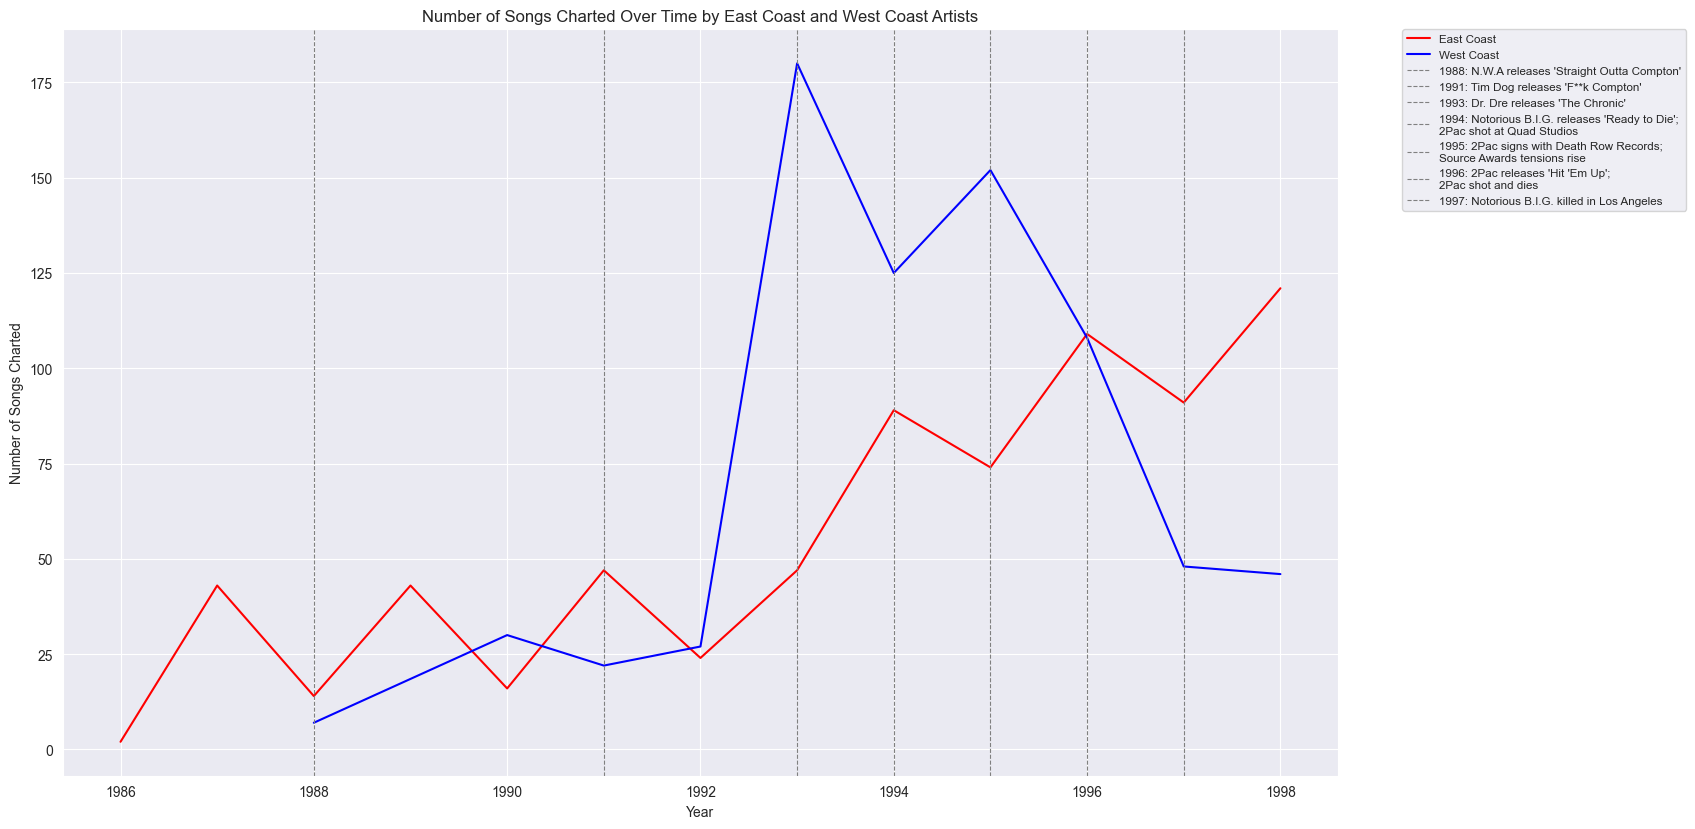

In [45]:
# Prepare data for east and west coast artists
east_mapped_artists = list(set(artist for artist in east_coast_artists if artist_mapping.get(artist)))
east_billboard_artists = [mapped for artist in east_mapped_artists for mapped in artist_mapping[artist]]
west_mapped_artists = list(set(artist for artist in west_coast_artists if artist_mapping.get(artist)))
west_billboard_artists = [mapped for artist in west_mapped_artists for mapped in artist_mapping[artist]]

# Filter data for each coast
filtered_east = filtered_billboard_df[filtered_billboard_df['performer'].isin(east_billboard_artists)].copy()
filtered_west = filtered_billboard_df[filtered_billboard_df['performer'].isin(west_billboard_artists)].copy()

# Group by year and count the number of songs on the chart
filtered_east.loc[:, 'year'] = pd.to_datetime(filtered_east['chart_week']).dt.year
filtered_west.loc[:, 'year'] = pd.to_datetime(filtered_west['chart_week']).dt.year

east_counts = filtered_east.groupby('year').size().reset_index(name='Count')
west_counts = filtered_west.groupby('year').size().reset_index(name='Count')
# east_counts['label'] = 'east_coast'
# west_counts['label'] = 'west_coast'

# combined_counts = pd.concat([east_counts, west_counts])
# combined_counts.to_csv('./combined_counts.csv')

plt.figure(figsize=(20, 8))  # Adjusted the figure width to make more space for the legend
plt.plot(east_counts['year'], east_counts['Count'], color='red', label='East Coast')
plt.plot(west_counts['year'], west_counts['Count'], color='blue', label='West Coast')

# Define the events with years and descriptions
events = {
    1988: "N.W.A releases 'Straight Outta Compton'",
    1991: "Tim Dog releases 'F**k Compton'",
    1993: "Dr. Dre releases 'The Chronic'",
    1994: "Notorious B.I.G. releases 'Ready to Die';\n2Pac shot at Quad Studios",
    1995: "2Pac signs with Death Row Records;\nSource Awards tensions rise",
    1996: "2Pac releases 'Hit 'Em Up';\n2Pac shot and dies",
    1997: "Notorious B.I.G. killed in Los Angeles"
}

# Plot vertical lines for each event with descriptions as labels
for year, description in events.items():
    plt.axvline(x=year, color='grey', linestyle='--', linewidth=0.8, label=f"{year}: {description}")

# Remove duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))

# Adjust legend position outside of the plot box
plt.legend(unique.values(), unique.keys(), loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small', borderaxespad=0)

# Adjust the plot area to make space for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust right boundary to make space for the legend


# Labels and title
plt.xlabel('Year')
plt.ylabel('Number of Songs Charted')
plt.title('Number of Songs Charted Over Time by East Coast and West Coast Artists')
plt.savefig('./Plots/number_of_songs_charted_over_time_per_coast_billboard.png', bbox_inches='tight')

plt.show()


In [46]:
combined_counts

NameError: name 'combined_counts' is not defined

In [ ]:
plt.figure(figsize=(14, 8))

# Plot scatter of peak positions over time for both coasts
plt.scatter(filtered_east['year'], filtered_east['peak_pos'], color='red', alpha=0.5, label='East Coast')
plt.scatter(filtered_west['year'], filtered_west['peak_pos'], color='blue', alpha=0.5, label='West Coast')

plt.xlabel('Year')
plt.ylabel('Peak Position (Lower is Better)')
plt.title('Peak Chart Position Over Time by Coast')
plt.gca().invert_yaxis()  # Lower numbers are better for peak positions
plt.legend()
plt.show()

In [ ]:
# Group by coast and sum weeks on chart
east_weeks = filtered_east['wks_on_chart'].sum()
west_weeks = filtered_west['wks_on_chart'].sum()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(['East Coast', 'West Coast'], [east_weeks, west_weeks], color=['red', 'blue'])
plt.xlabel('Coast')
plt.ylabel('Total Weeks on Chart')
plt.title('Total Weeks on Billboard Hot 100 Chart by Coast')
plt.show()

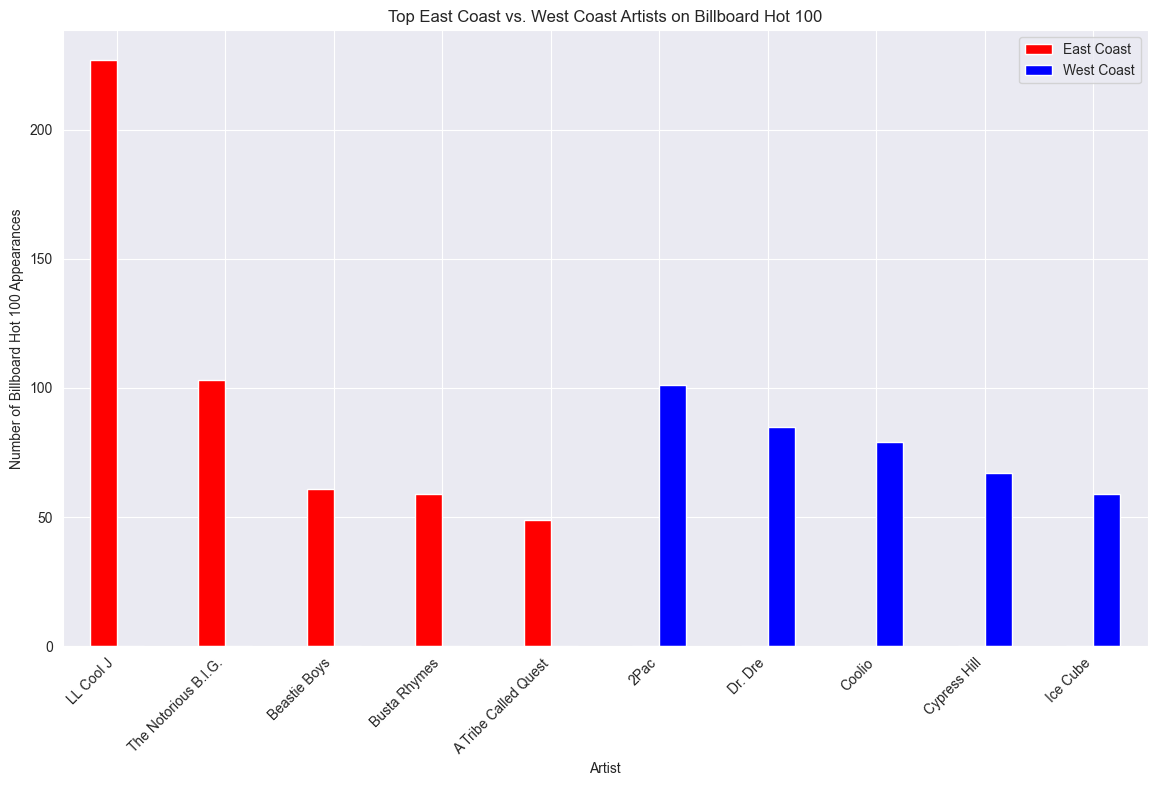

In [47]:
# Get top east coast and west coast artists by number of appearances on the Billboard Hot 100
east_artist_counts = filtered_east['performer'].value_counts().nlargest(5)
west_artist_counts = filtered_west['performer'].value_counts().nlargest(5)

# Concatenate into one DataFrame for easier plotting
top_artists = pd.concat([east_artist_counts, west_artist_counts], axis=1).fillna(0)
top_artists.columns = ['East Coast', 'West Coast']

# Plot the top artists with their counts
top_artists.plot(kind='bar', figsize=(14, 8), color=['red', 'blue'])
plt.xlabel('Artist')
plt.ylabel('Number of Billboard Hot 100 Appearances')
plt.title('Top East Coast vs. West Coast Artists on Billboard Hot 100')
plt.xticks(rotation=45, ha='right')
plt.savefig('top_east_west_coast_billboard_artist.png')
plt.show()